# Reconstructed cell neurite lengths
Plotting both (1) path length distances to the leaves of the skeletons and (2) the dendritic lengths reconstructed as a percentage of the expected value.

In [1]:
import numpy as np
import pandas as pd
import random
from scipy import stats

from matplotlib import rcParams as rc
from matplotlib import pyplot as plt

from lib import plot, u

In [2]:
rc.update({'font.size': 20})

## Reading data

In [3]:
pyr_leaves_raw = pd.read_csv('data/pyr_neurite_lengths.csv', index_col=0)
inh_leaves = pd.read_csv('data/inh_neurite_lengths.csv', index_col=0)

In [4]:
pyr_complengths_raw = pd.read_csv('data/pyr_compartment_lengths.csv', index_col=0)

In [5]:
pyrs_clean_compartments = u.read_ids("data/clean_compartment_ids_v185.csv")

In [6]:
pyr_leaves = pyr_leaves_raw[pyr_leaves_raw.pt_root_id.isin(pyrs_clean_compartments)]
pyr_complengths = pyr_complengths_raw[
    pyr_complengths_raw.cellid.isin(pyrs_clean_compartments)]

In [7]:
pyr_leaves.head()

,cell_type,pt_position,pt_root_id,axon_lengths_um,apical_dend_lengths_um,basal_dend_lengths_um,ambiguous_dend_lengths_um
1,e,[84054 50604 1424],648518346349538466,[59.05064129049888],"[146.08713414259014, 135.36520528654188, 85.83...","[146.08713414259014, 135.36520528654188, 85.83...","[44.28541110779654, 97.37027331260785, 64.9004..."
4,e,[77197 61773 428],648518346349537038,[41.19627002083458],"[137.72780212763544, 107.79859845784608, 112.9...","[137.72780212763544, 107.79859845784608, 112.9...","[107.99619551700981, 107.82882130638531, 54.53..."
7,e,[65539 51308 977],648518346349539068,"[170.20112486534458, 198.98896093447883, 131.8...","[79.20691470226744, 66.61165006566337, 69.3832...","[79.20691470226744, 66.61165006566337, 69.3832...","[58.38731102396065, 52.83220245412832, 55.1583..."
8,e,[100898 43550 891],648518346349536988,"[261.8033724510187, 240.47636833541313, 162.86...","[101.10263616447452, 97.56225955655388, 100.04...","[101.10263616447452, 97.56225955655388, 100.04...",[12.938807616144814]
12,e,[101740 53066 718],648518346349539539,"[213.17479986917263, 239.04001396970457, 221.5...","[123.5473979054038, 89.6978445003813, 81.93792...","[123.5473979054038, 89.6978445003813, 81.93792...","[117.61770901976443, 48.600260876360515, 77.36..."


In [8]:
pyr_complengths.head()

,cellid,soma_length_um,axon_length_um,basal_length_um,apical_length_um,ambiguous dendrite_length_um,ambiguous_length_um
4,648518346349522862,15.009022,0.000000,192.778053,0.000000,0.0,0.0
12,648518346349523129,37.956093,0.000000,327.055188,567.679268,0.0,0.0
13,648518346349533252,64.470290,0.000000,351.839554,141.306714,0.0,0.0
16,648518346349538001,27.844939,0.000000,0.000000,885.007456,0.0,0.0
17,648518346349539414,143.935690,63.255578,1384.713261,543.477423,0.0,0.0


## Formatting data

In [9]:
def length_frame(df, lengthcol, celltype, neuritetype):
    cellids, lengths, celltypes, neuritetypes = [], [], [], []
    
    for (cellid, lens) in zip(df["pt_root_id"], df[lengthcol]):
        for length in eval(lens):
            cellids.append(cellid)
            lengths.append(length)
            celltypes.append(celltype)
            neuritetypes.append(neuritetype)
    
    data_dict = {
        "cellid": pd.Series(cellids, dtype="int"),
        "neuritelength": lengths,
        "celltype": celltypes,
        "neuritetype": neuritetypes
    }

    return pd.DataFrame(data_dict)


def assemble_pyr_data(df):
    axondf = length_frame(df, "axon_lengths_um", "pyramidal", "axon")
    basaldf = length_frame(df, "basal_dend_lengths_um", "pyramidal", "basal")
    apicaldf = length_frame(df, "apical_dend_lengths_um", "pyramidal", "apical")
    
    return pd.concat((axondf, basaldf, apicaldf), ignore_index=True)


def assemble_inh_data(df):
    typedfs = []
    for (typename, subdf) in df.groupby("forrest_tag"):
        typedfs.append(assemble_typedf(subdf, typename))
    
    return pd.concat(typedfs, ignore_index=True)


def assemble_typedf(df, celltype):
    neuritedfs = []
    axondf = length_frame(df, "axon_lengths_um", celltype, "axon")
    denddf = length_frame(df, "dendrite_lengths_um", celltype, "dendrite")
    
    return pd.concat((axondf, denddf), ignore_index=True)


def assemble_all_data():
    pyrdf = assemble_pyr_data(pyr_leaves)
    inhdf = assemble_inh_data(inh_leaves)
    
    return pd.concat((pyrdf, inhdf), ignore_index=True)

In [10]:
leafdata = assemble_all_data()

In [11]:
leafdata.head()

,cellid,neuritelength,celltype,neuritetype
0,648518346349538466,59.050641,pyramidal,axon
1,648518346349537038,41.196270,pyramidal,axon
2,648518346349539068,170.201125,pyramidal,axon
3,648518346349539068,198.988961,pyramidal,axon
4,648518346349539068,131.830306,pyramidal,axon


In [12]:
leafdata.loc[leafdata.celltype == "unknown_type", "celltype"] = "unclassified"

In [13]:
plotdf = leafdata.groupby(["cellid", "celltype", "neuritetype"])["neuritelength"].\
    quantile([0.05, 0.5, 0.95]).unstack().reset_index()

In [14]:
plotdf.head()

,cellid,celltype,neuritetype,0.05,0.5,0.95
0,648518346349477331,bipolar,axon,66.320367,182.381953,321.115928
1,648518346349477331,bipolar,dendrite,14.907629,41.191849,115.981463
2,648518346349487432,bipolar,dendrite,5.608375,50.099377,106.246134
3,648518346349487752,bipolar,axon,41.109148,41.109148,41.109148
4,648518346349487752,bipolar,dendrite,14.267682,59.603715,134.409277


In [15]:
plotdf["celltype"] = [c.capitalize() for c in plotdf.celltype]

## Plotting

#### Distances to leaves (neurite length from soma)

In [16]:
def _errorbar_w_jitter(xs, ys, errslow, errshi,
                      jitter=0.2, seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)

    xs = xs + stats.uniform(-jitter, 2*jitter).rvs(len(xs))
    low = ys - errslow
    hi = errshi - ys
    
    plt.errorbar(xs, ys, yerr=[low, hi],
                 marker='', linestyle='', color="tab:gray")
    plt.scatter(xs, ys, marker='o', s=20, color='k', zorder=10)
    

def errorbar_w_jitter(df, levels, levelcolname="celltype",
                      seed=None, level_xs=None):
    df = df[df[levelcolname].isin(levels)]
    
    if level_xs is None:
        level_xs = list(range(len(levels)))

    levelmap = {level: x for (level, x) in zip(levels, level_xs)}
    xs = [levelmap[v] for v in df[levelcolname]]
    
    _errorbar_w_jitter(xs, df[0.5], df[0.05], df[0.95], seed=seed)
    
    plt.xticks(level_xs, levels, rotation=45)

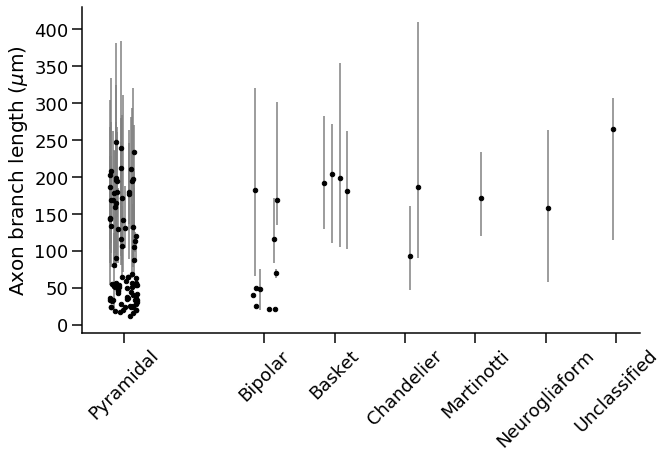

In [17]:
plt.figure(figsize=(10, 6))
levels = ["Pyramidal", "Bipolar", "Basket",
          "Chandelier", "Martinotti",
          "Neurogliaform", "Unclassified"]

errorbar_w_jitter(plotdf[plotdf.neuritetype == "axon"], levels,
                  level_xs = [0, 2, 3, 4, 5, 6, 7], seed=67234697)
plt.ylabel("Axon branch length ($\mu$m)")

plot.format_axes()
plt.show()

In [18]:
denddf = plotdf[plotdf.neuritetype != "axon"]

full_neuritetype = []
for (celltype, neuritetype) in zip(denddf.celltype, denddf.neuritetype):
    if celltype != "Pyramidal":
        full_neuritetype.append(celltype)
    else:
        full_neuritetype.append(f"{celltype}\n{neuritetype}")

denddf.loc[:, "full_celltype"] = full_neuritetype

/usr/people/nturner/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


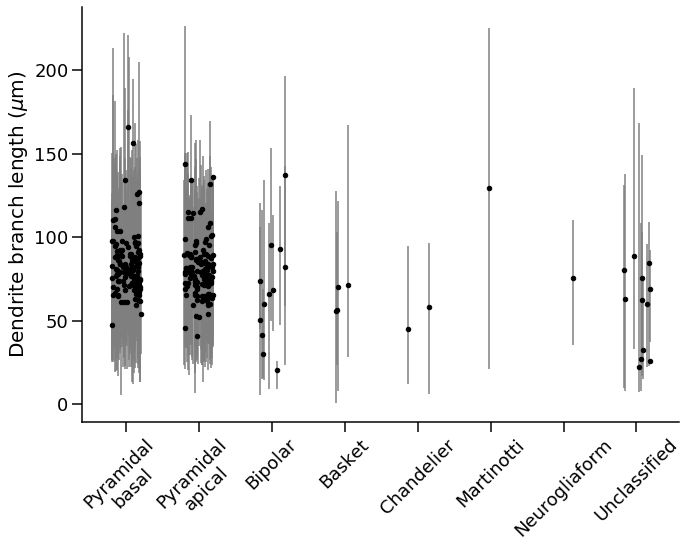

In [26]:
plt.figure(figsize=(10, 8))
levels = ["Pyramidal\nbasal", "Pyramidal\napical",
          "Bipolar", "Basket", "Chandelier", "Martinotti",
          "Neurogliaform", "Unclassified"]

errorbar_w_jitter(denddf, levels, levelcolname="full_celltype", seed=67234697)
plt.ylabel("Dendrite branch length ($\mu$m)")

plot.format_axes()
plt.tight_layout()
plt.savefig("assets/dendritelength.png")
plt.show()

### Percentage completion

In [20]:
pyr_complengths.head()

,cellid,soma_length_um,axon_length_um,basal_length_um,apical_length_um,ambiguous dendrite_length_um,ambiguous_length_um
4,648518346349522862,15.009022,0.000000,192.778053,0.000000,0.0,0.0
12,648518346349523129,37.956093,0.000000,327.055188,567.679268,0.0,0.0
13,648518346349533252,64.470290,0.000000,351.839554,141.306714,0.0,0.0
16,648518346349538001,27.844939,0.000000,0.000000,885.007456,0.0,0.0
17,648518346349539414,143.935690,63.255578,1384.713261,543.477423,0.0,0.0


In [21]:
pyr_complengths.loc[:, "dend_length_um"] = (
    pyr_complengths["apical_length_um"] +
    pyr_complengths["ambiguous dendrite_length_um"] +
    pyr_complengths["basal_length_um"])

/usr/people/nturner/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [22]:
def plotpercentagehist(data, bins):
    plt.hist(data, color='k', bins=bins)
    plt.xticks(np.arange(11) * 0.1, np.arange(11) * 10, fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(0, 1)

Average path lengths from [Gilman, Medalla & Luebke 2017](https://doi.org/10.1093/cercor/bhw062):  

* Dendrite arbor - 4.291mm  
* Basal arbor - 2.583mm
* Apical arbor - 1.707mm

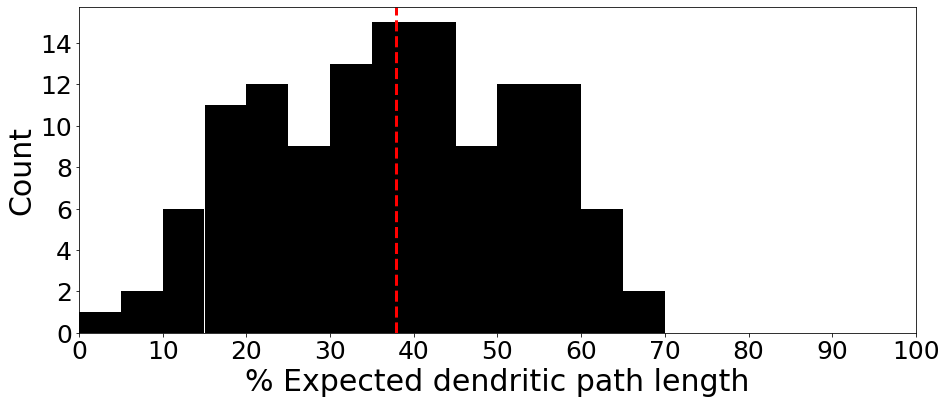

In [23]:
plt.figure(figsize=(15, 6))
  
bins = np.arange(21) * 0.05
percentages = pyr_complengths.dend_length_um / 4291
plotpercentagehist(percentages, bins)

plt.axvline(np.percentile(percentages, 50), ls='--', lw=3, color='r')

plt.xlabel("% Expected dendritic path length", fontsize=30)
plt.ylabel("Count", fontsize=30)

plt.show()

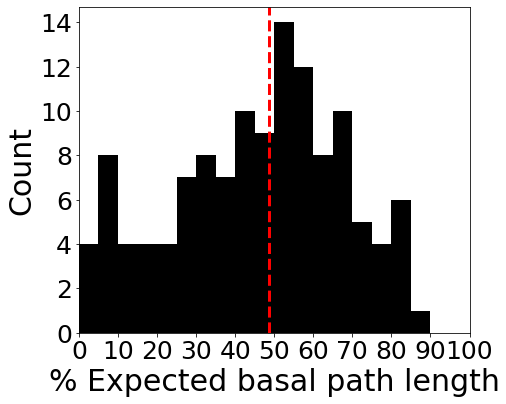

In [24]:
plt.figure(figsize=(7, 6))
  
bins = np.arange(21) * 0.05
percentages = pyr_complengths.basal_length_um / 2583
plotpercentagehist(percentages, bins)

plt.axvline(np.percentile(percentages, 50), ls='--', lw=3, color='r')

plt.xlabel("% Expected basal path length", fontsize=30)
plt.ylabel("Count", fontsize=30)

plt.show()

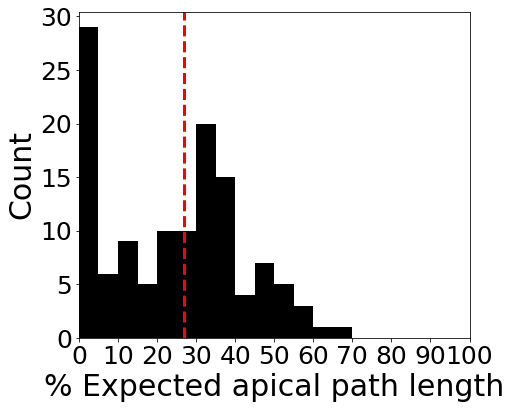

In [25]:
plt.figure(figsize=(7, 6))
  
bins = np.arange(21) * 0.05
percentages = pyr_complengths.apical_length_um / 1707
plotpercentagehist(percentages, bins)

plt.axvline(np.percentile(percentages, 50), ls='--', lw=3, color='r')

plt.xlabel("% Expected apical path length", fontsize=30)
plt.ylabel("Count", fontsize=30)

plt.show()